First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here.

In [54]:
import pandas as pd

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', '../data/train3.pkl')
repackage('../data/203_test.p', '../data/test3.pkl')

In [80]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6 #
print(X.timestamp)
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
print(X.timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

2018-02-16 03:48:43.080000
2018-02-16 03:48:43.108000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752923108000000
dtype: object

## Learn  a model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, predict, compute_tau

trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)

np.random.seed(12345)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ixs = trajs.traj.unique()

Optimization restart 1/1, f = -195.18543525540136


Optimization restart 1/1, f = -5979.750051088031


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:109: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/1, f = -189.35617515365064


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


GP_regression.,value,constraints,priors
rbf.variance,1.1982925632254238,+ve,
rbf.lengthscale,0.5365317392147627,+ve,
Gaussian_noise.variance,2.2993126962217193e-05,+ve,


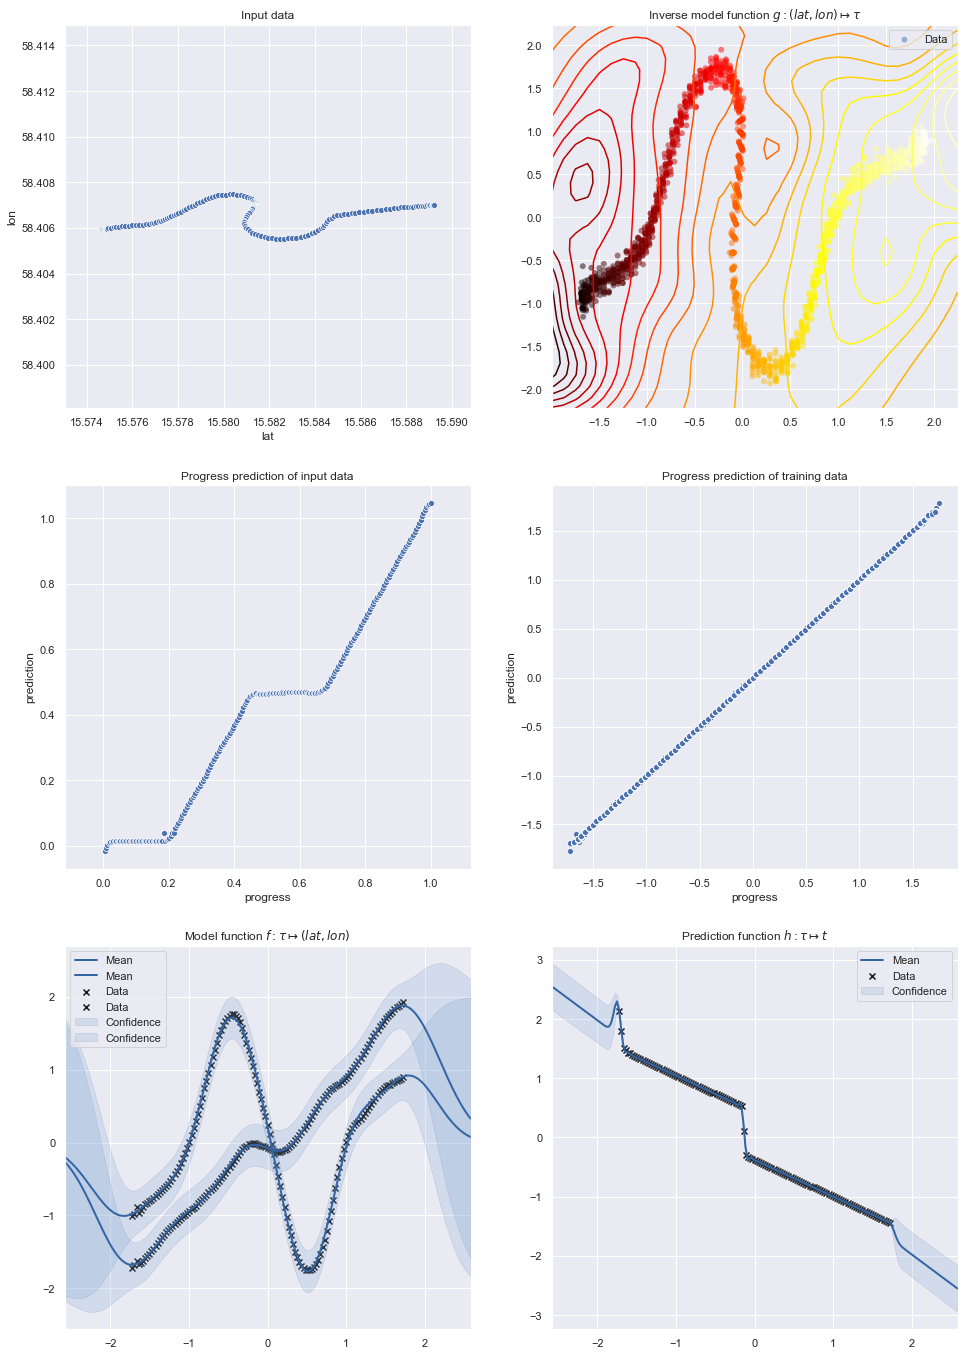

In [12]:

%matplotlib inline
sns.set(style="darkgrid")

f_priors = FunctionModelPriors(None, None, None)
g_kern_ls_prior = None #gamma_prior(0.5, .002)
g_kern_var_prior = None # gamma_prior(1, .5)
g_kern_lik_prior = None
g_priors = FunctionModelPriors(
    g_kern_ls_prior, 
    g_kern_var_prior, 
    g_kern_lik_prior)
h_priors = FunctionModelPriors(None, None, None)

route_n = 3
seg_n = 9
n_restarts = 1
fix_f_likelihood = 0.02
n_augment_samples = 15
augment_sigma = 0.00005
augment_delta = 0.01
stop_compress_delta=5e-3
seg_one = trajs[(trajs.traj == traj_ixs[0]) & (trajs.seg == seg_n)]
codomain_f = ['lat', 'lon']
domain_h = ['lat', 'lon']
m = learn_trajectory_model(
    seg_one, 
    route_n,
    seg_n,
    codomain_f, 
    domain_h,
    f_priors=f_priors,
    g_priors=g_priors,
    h_priors=h_priors,
    n_restarts=n_restarts,    
    stop_compress_delta=stop_compress_delta,
    fix_f_likelihood=fix_f_likelihood,
    n_augment_samples=n_augment_samples,
    augment_sigma=augment_sigma,
    augment_delta=augment_delta)

n_rows = 3
n_cols = 2
fig_size = 8
_fig, axs = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols, 
    figsize=(fig_size*n_cols, 
             fig_size*n_rows))

# Input data
sns.scatterplot(data=seg_one, x='lat', y='lon', ax=axs[0][0])
axs[0][0].set_title('Input data')
axs[0, 0].set_aspect('equal', 'datalim')

# h for input data
mean, _  = predict(m.g, seg_one[['lat', 'lon']].values)
progress = compute_tau(seg_one)
df = pd.DataFrame({'prediction': mean.T[0], 'progress': progress})
sns.scatterplot(data=df, x='progress', y='prediction', ax=axs[1][0])
axs[1][0].set_title('Progress prediction of input data')
axs[1, 0].set_aspect('equal', 'datalim')

# Training data
plot_function(m.g, ax=axs[0][1])
axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')

# H for training data
mean, _  = m.g.model.predict(m.g.model.X)
df = pd.DataFrame({'prediction': mean.T[0], 'progress': m.g.model.Y.flatten()})
sns.scatterplot(data=df, x='progress', y='prediction', ax=axs[1][1])
axs[1][1].set_title('Progress prediction of training data')

# f
plot_function(m.f, ax=axs[2][0])
axs[2][0].set_title(r'Model function $f: \tau \mapsto (lat, lon)$')

# h
plot_function(m.h, ax=axs[2][1])
axs[2][1].set_title(r'Prediction function $h: \tau \mapsto t$')

m.g.model

In [6]:
from model import compute_tau, create_support_data

delta = 0.1
data['tau'] = compute_tau(data)
tau_grid = np.linspace(
    np.min(data.tau.min()),
    np.min(data.tau.max()),
    1/delta
)
tau_grid

array([3.61080830e-07, 1.11111432e-01, 2.22222503e-01, 3.33333574e-01,
       4.44444645e-01, 5.55555716e-01, 6.66666787e-01, 7.77777858e-01,
       8.88888929e-01, 1.00000000e+00])

In [ ]:
# data augmentation experiment

support_data = create_support_data(data, m.f, 10, 0.1, 1)
support_data.head()

In [5]:
x = np.array([1,2,3])
x = x / np.linalg.norm(x)
x

array([0.26726124, 0.53452248, 0.80178373])

## Learn many models

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict

np.random.seed(12345)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)

# Settings for GP models
seg_n = 2
route_n = 3
n_restarts = 3
fix_f_likelihood = 0.02
n_augment_samples = 15
augment_sigma = 1.1
stop_compress_delta=5e-3
codomain_f = ['lat', 'lon']
domain_h = ['lat', 'lon']
f_priors = FunctionModelPriors(None, None, None)
g_priors = FunctionModelPriors(None, None, None)
h_priors = FunctionModelPriors(None, None, None)
verbose=False

trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ixs = trajs.traj.unique()
trajs = trajs[trajs.seg == seg_n]
trajs = dict(tuple(trajs.groupby('traj')))

conn = acquire_db_conn()

for traj_n in tqdm(trajs_to_use):
    traj = trajs[traj_n]
    m = learn_trajectory_model(
        traj,
        route_n,
        seg_n,
        codomain_f, 
        domain_h,
        f_priors=f_priors,
        g_priors=g_priors,
        h_priors=h_priors,
        n_restarts=n_restarts,    
        stop_compress_delta=stop_compress_delta,
        fix_f_likelihood=fix_f_likelihood,
        n_augment_samples=n_augment_samples,
        augment_sigma=augment_sigma,
        verbose=verbose)
    save_model(m, conn)
        

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Optimization restart 1/3, f = -145.95726453147012
Optimization restart 2/3, f = -145.95726453089543
Optimization restart 3/3, f = -145.95726453139983
Optimization restart 1/3, f = -564.0575045716506
Optimization restart 2/3, f = -564.0575045938468
Optimization restart 3/3, f = -564.0575045938674


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -58.110024431898026
Optimization restart 2/3, f = -58.11002443082287
Optimization restart 3/3, f = -58.110024431605325
22 23 24


  5%|████▏                                                                              | 1/20 [00:04<01:27,  4.59s/it]

Optimization restart 1/3, f = -90.11083596351182
Optimization restart 2/3, f = -90.1108359635083
Optimization restart 3/3, f = -90.11083596363581
Optimization restart 1/3, f = -449.7725369106185
Optimization restart 2/3, f = -449.7725369317219
Optimization restart 3/3, f = -449.7725369319551


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -25.309925708481387
Optimization restart 2/3, f = -25.309925701651167
Optimization restart 3/3, f = -25.309925708467162
25 26 27


 10%|████████▎                                                                          | 2/20 [00:08<01:17,  4.28s/it]

Optimization restart 1/3, f = -113.72167396895765
Optimization restart 2/3, f = -113.72167396839416
Optimization restart 3/3, f = -113.72167396857836
Optimization restart 1/3, f = -565.4295339926339
Optimization restart 2/3, f = -565.4295448661517
Optimization restart 3/3, f = -565.4295448660637


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -37.67507098460012
Optimization restart 2/3, f = -37.675070984488855
Optimization restart 3/3, f = -37.67507098463991
28 29 30


 15%|████████████▍                                                                      | 3/20 [00:12<01:11,  4.22s/it]

Optimization restart 1/3, f = -99.25357691803549
Optimization restart 2/3, f = -99.25357691759534
Optimization restart 3/3, f = -99.25357691806079
Optimization restart 1/3, f = -453.67744707284095
Optimization restart 2/3, f = -453.6774470726158
Optimization restart 3/3, f = -453.67744707289006


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -24.972382368152374
Optimization restart 2/3, f = -24.97238233206761
Optimization restart 3/3, f = -24.972382367639852
31 32 33


 20%|████████████████▌                                                                  | 4/20 [00:15<01:05,  4.08s/it]

Optimization restart 1/3, f = -112.6455476605479
Optimization restart 2/3, f = -112.64554765998503
Optimization restart 3/3, f = -112.6455476605004
Optimization restart 1/3, f = -586.2944803728093
Optimization restart 2/3, f = -586.2944803727837
Optimization restart 3/3, f = -586.2944803727725


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -28.134497859804917
Optimization restart 2/3, f = -28.13449785959538
Optimization restart 3/3, f = -28.134497859862048
34 35 36


 25%|████████████████████▊                                                              | 5/20 [00:21<01:07,  4.48s/it]

Optimization restart 1/3, f = -116.80618754906592
Optimization restart 2/3, f = -116.80618754904849
Optimization restart 3/3, f = -116.80618754906948
Optimization restart 1/3, f = -529.7117317677252
Optimization restart 2/3, f = -529.7117318429673
Optimization restart 3/3, f = -529.7117318430433


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -18.015294051513536
Optimization restart 2/3, f = -18.01529405218789
Optimization restart 3/3, f = -18.015294052187695
37 38 39


 30%|████████████████████████▉                                                          | 6/20 [00:25<01:02,  4.43s/it]

Optimization restart 1/3, f = -140.53360396712364
Optimization restart 2/3, f = -140.5336039685535
Optimization restart 3/3, f = -140.53360396652633
Optimization restart 1/3, f = -395.19620907254017
Optimization restart 2/3, f = -395.1962090724834
Optimization restart 3/3, f = -395.196209072553


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/3, f = -183.66946638394884
Optimization restart 2/3, f = -183.42759432199963
Optimization restart 3/3, f = -183.6675860807528
40 41 42


 35%|█████████████████████████████                                                      | 7/20 [00:28<00:51,  3.98s/it]

Optimization restart 1/3, f = -79.7292804665949
Optimization restart 2/3, f = -79.72928046888737
Optimization restart 3/3, f = -79.7292804670264
Optimization restart 1/3, f = -500.05466276555035
Optimization restart 2/3, f = -500.0546627648398
Optimization restart 3/3, f = -500.0546627655612


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -19.261417539988013
Optimization restart 2/3, f = -19.2614175407224
Optimization restart 3/3, f = -19.261417540722814
43 44 45


 40%|█████████████████████████████████▏                                                 | 8/20 [00:33<00:49,  4.11s/it]

Optimization restart 1/3, f = -121.43420352038741
Optimization restart 2/3, f = -121.43420352039558
Optimization restart 3/3, f = -121.43420352039632
Optimization restart 1/3, f = -605.401049099669
Optimization restart 2/3, f = -605.4010491006638
Optimization restart 3/3, f = -605.4010491007073


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -54.2637761690268
Optimization restart 2/3, f = -54.26377616898493
Optimization restart 3/3, f = -54.26377616850855
46 47 48


 45%|█████████████████████████████████████▎                                             | 9/20 [00:38<00:48,  4.45s/it]

Optimization restart 1/3, f = -102.35274880456362
Optimization restart 2/3, f = -102.35274880177272
Optimization restart 3/3, f = -102.35274879891782
Optimization restart 1/3, f = -512.7538411796405
Optimization restart 2/3, f = -512.7538411797077
Optimization restart 3/3, f = -512.753841180023


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -28.872736717399018
Optimization restart 2/3, f = -28.872736717531044
Optimization restart 3/3, f = -28.872736717523896
49 50 51


 50%|█████████████████████████████████████████                                         | 10/20 [00:42<00:43,  4.35s/it]

Optimization restart 1/3, f = -94.1685128623051
Optimization restart 2/3, f = -94.16851286203222
Optimization restart 3/3, f = -94.16851286200892
Optimization restart 1/3, f = -466.6281837614772
Optimization restart 2/3, f = -466.6281837614507
Optimization restart 3/3, f = -466.6281837615256


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -44.39340436406758
Optimization restart 2/3, f = -44.39340436489904
Optimization restart 3/3, f = -44.39340436500488
52 53 54


 55%|█████████████████████████████████████████████                                     | 11/20 [00:46<00:39,  4.36s/it]

Optimization restart 1/3, f = -116.8785906606433
Optimization restart 2/3, f = -116.87859066052553
Optimization restart 3/3, f = -116.87859066064291
Optimization restart 1/3, f = -590.1718326212448
Optimization restart 2/3, f = -590.1718326517981
Optimization restart 3/3, f = -590.1718326521055


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -53.65650674326328
Optimization restart 2/3, f = -53.65650674301921
Optimization restart 3/3, f = -53.65650674328735
55 56 57


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:51<00:36,  4.58s/it]

Optimization restart 1/3, f = -92.6434131908622
Optimization restart 2/3, f = -92.64341319049362
Optimization restart 3/3, f = -92.64341319087717
Optimization restart 1/3, f = -558.6034704312732
Optimization restart 2/3, f = -558.6034704137452
Optimization restart 3/3, f = -558.6034704312372


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -48.509083513733984
Optimization restart 2/3, f = -48.509083513636014
Optimization restart 3/3, f = -48.50908351369075
58 59 60


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:56<00:33,  4.73s/it]

Optimization restart 1/3, f = -130.94519462014756
Optimization restart 2/3, f = -130.9451946200906
Optimization restart 3/3, f = -130.94519461956418
Optimization restart 1/3, f = -543.1626614134381
Optimization restart 2/3, f = -543.1626613983639
Optimization restart 3/3, f = -543.1626614134142


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -11.199529735457777
Optimization restart 2/3, f = -11.199529735899496
Optimization restart 3/3, f = -11.199529735892735
61 62 63


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:01<00:27,  4.56s/it]

Optimization restart 1/3, f = -115.272337996998
Optimization restart 2/3, f = -115.2723379970236
Optimization restart 3/3, f = -115.27233799656248
Optimization restart 1/3, f = -581.8126359234918
Optimization restart 2/3, f = -581.812635923581
Optimization restart 3/3, f = -581.8126359221635


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -35.76216360132227
Optimization restart 2/3, f = -35.76216360120662
Optimization restart 3/3, f = -35.76216360117963
64 65 66


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:06<00:24,  4.93s/it]

Optimization restart 1/3, f = -107.84560629077188
Optimization restart 2/3, f = -107.84560629027898
Optimization restart 3/3, f = -107.84560629029393
Optimization restart 1/3, f = -473.93093783973177
Optimization restart 2/3, f = -473.93093785896883
Optimization restart 3/3, f = -473.9309378589062


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = 0.06352326860508128
Optimization restart 2/3, f = 0.06352326861514612
Optimization restart 3/3, f = 0.06352326860407587
67 68 69


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:10<00:18,  4.55s/it]

Optimization restart 1/3, f = -98.85160641627142
Optimization restart 2/3, f = -98.8516064167217
Optimization restart 3/3, f = -98.8516064164117
Optimization restart 1/3, f = -491.5886158617695
Optimization restart 2/3, f = -491.58861586177073
Optimization restart 3/3, f = -491.5886158604535


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -44.49243694419812
Optimization restart 2/3, f = -44.49243694458869
Optimization restart 3/3, f = -44.49243694397828
70 71 72


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:14<00:12,  4.32s/it]

Optimization restart 1/3, f = -94.55350238833473
Optimization restart 2/3, f = -94.55350238834538
Optimization restart 3/3, f = -94.55350238835794
Optimization restart 1/3, f = -458.98509486658764
Optimization restart 2/3, f = -458.9850948663297
Optimization restart 3/3, f = -458.9850948665551


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -5.833776089492119
Optimization restart 2/3, f = -5.83377608949062
Optimization restart 3/3, f = -5.8337760894982615
73 74 75


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:18<00:08,  4.16s/it]

Optimization restart 1/3, f = -145.47856531550082
Optimization restart 2/3, f = -145.4785653128498
Optimization restart 3/3, f = -145.47856531542297
Optimization restart 1/3, f = -332.6033437213711
Optimization restart 2/3, f = -332.60334372786633
Optimization restart 3/3, f = -332.60334372811195


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -158.97554948200428
Optimization restart 2/3, f = -158.97709732268802
Optimization restart 3/3, f = -158.97181818604824
76 77 78


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:19<00:03,  3.30s/it]

Optimization restart 1/3, f = -129.1736782826703
Optimization restart 2/3, f = -129.17367828222737
Optimization restart 3/3, f = -129.17367828271958
Optimization restart 1/3, f = -572.45021964263
Optimization restart 2/3, f = -572.4502196417747
Optimization restart 3/3, f = -572.4502196426056


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:94: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.


Optimization restart 1/3, f = -70.09163974581638
Optimization restart 2/3, f = -70.09163974798304
Optimization restart 3/3, f = -70.09163973019932
79 80 81


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  3.70s/it]


## Load many models and make predictions

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from collections import defaultdict
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models, compute_tau

route_n = 3
seg_n = 2
conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)
    
'loaded {} models'.format(len(models))

'loaded 20 models'

In [2]:
def data_loglik(model: FunctionModel, X, Y):
    def loglik(x, y):
        mu, sigma = predict(model, x.reshape(1, 1))
        return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                -0.5*np.log(np.abs(sigma))
    return np.sum([loglik(x, y) for x, y in zip(X, Y)])

def model_likelihood(model: TrajectoryModel, data: DataFrame) -> float:
    data['tau'] = compute_tau(data)
    X = data[['tau']].values
    Y = data[['lat', 'lon']].values
    loglik = data_loglik(model.f, X, Y)
    
    
här ska vi kolla upp vad tusan loglikelihood-functionen egentligen ska göra    

In [19]:
np.random.seed(12345)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
seg_sizes = [.2, .4, .6, .8]
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
segs = dict(tuple(data.groupby('seg')))
for seg_i, seg_n in enumerate(segs):
    seg = segs[seg_n]
    trajs = dict(tuple(seg.groupby('traj')))
    for traj_i, traj_n in enumerate(trajs):
        traj_data = trajs[traj_n]
        model_likelihoods = [model_likelihood(m, traj_data) for m in models]
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        logliks = [data_loglik(lg, X, Y) for lg in lik_gps[seg_n]]
            

(77, 12)
(198, 12)
(185, 12)
(194, 12)
(198, 12)
(190, 12)
(209, 12)
(123, 12)
(185, 12)
(261, 12)
(203, 12)
(189, 12)
(214, 12)
(217, 12)
(201, 12)
(188, 12)
(223, 12)
(200, 12)
(197, 12)
(180, 12)
(231, 12)
(190, 12)
(155, 12)
(175, 12)
(204, 12)
(273, 12)
(187, 12)
(178, 12)
(303, 12)
(191, 12)
(207, 12)
(207, 12)
(206, 12)
(208, 12)
(190, 12)
(217, 12)
(194, 12)
(185, 12)
(181, 12)
(202, 12)
(208, 12)
(254, 12)
(187, 12)
(192, 12)
(266, 12)
(170, 12)
(304, 12)
(210, 12)
(216, 12)
(226, 12)
(191, 12)
(91, 12)
(239, 12)
(172, 12)
(203, 12)
(241, 12)
(193, 12)
(212, 12)
(189, 12)
(194, 12)
(164, 12)
(195, 12)
(181, 12)
(189, 12)
(304, 12)
(189, 12)
(203, 12)
(180, 12)
(184, 12)
(218, 12)
(224, 12)
(198, 12)
(206, 12)
(151, 12)
(216, 12)
(259, 12)
(380, 12)
(189, 12)
(138, 12)
(178, 12)
(209, 12)
(214, 12)
(205, 12)
(192, 12)
(228, 12)
(207, 12)
(199, 12)
(190, 12)
(189, 12)
(192, 12)
(227, 12)
(162, 12)
(182, 12)
(193, 12)
(234, 12)
(178, 12)
(233, 12)
(217, 12)
(212, 12)
(213, 12)
(1

(182, 12)
(215, 12)
(179, 12)
(210, 12)
(188, 12)
(181, 12)
(192, 12)
(224, 12)
(308, 12)
(176, 12)
(182, 12)
(202, 12)
(186, 12)
(89, 12)
(194, 12)
(188, 12)
(242, 12)
(217, 12)
(212, 12)
(162, 12)
(198, 12)
(253, 12)
(182, 12)
(192, 12)
(202, 12)
(191, 12)
(180, 12)
(184, 12)
(186, 12)
(210, 12)
(204, 12)
(205, 12)
(195, 12)
(240, 12)
(181, 12)
(203, 12)
(170, 12)
(184, 12)
(107, 12)
(173, 12)
(185, 12)
(219, 12)
(187, 12)
(140, 12)
(197, 12)
(202, 12)
(264, 12)
(196, 12)
(95, 12)
(187, 12)
(66, 12)
(178, 12)
(187, 12)
(260, 12)
(111, 12)
(189, 12)
(244, 12)
(173, 12)
(239, 12)
(202, 12)
(175, 12)
(267, 12)
(179, 12)
(247, 12)
(185, 12)
(215, 12)
(199, 12)
(199, 12)
(180, 12)
(196, 12)
(206, 12)
(168, 12)
(217, 12)
(215, 12)
(181, 12)
(312, 12)
(197, 12)
(227, 12)
(195, 12)
(198, 12)
(250, 12)
(107, 12)
(195, 12)
(272, 12)
(191, 12)
(116, 12)
(111, 12)
(205, 12)
(205, 12)
(181, 12)
(197, 12)
(187, 12)
(190, 12)
(201, 12)
(200, 12)
(96, 12)
(184, 12)
(266, 12)
(186, 12)
(253, 12)
(198

(53, 12)
(55, 12)
(61, 12)
(61, 12)
(31, 12)
(60, 12)
(66, 12)
(67, 12)
(55, 12)
(62, 12)
(80, 12)
(56, 12)
(31, 12)
(58, 12)
(61, 12)
(54, 12)
(33, 12)
(35, 12)
(27, 12)
(31, 12)
(53, 12)
(36, 12)
(55, 12)
(37, 12)
(35, 12)
(57, 12)
(27, 12)
(31, 12)
(60, 12)
(85, 12)
(61, 12)
(66, 12)
(62, 12)
(63, 12)
(63, 12)
(57, 12)
(58, 12)
(56, 12)
(70, 12)
(70, 12)
(74, 12)
(58, 12)
(33, 12)
(77, 12)
(65, 12)
(60, 12)
(74, 12)
(65, 12)
(77, 12)
(29, 12)
(57, 12)
(88, 12)
(51, 12)
(66, 12)
(58, 12)
(53, 12)
(67, 12)
(30, 12)
(94, 12)
(54, 12)
(65, 12)
(51, 12)
(74, 12)
(63, 12)
(67, 12)
(32, 12)
(60, 12)
(62, 12)
(62, 12)
(37, 12)
(59, 12)
(54, 12)
(79, 12)
(53, 12)
(38, 12)
(51, 12)
(34, 12)
(36, 12)
(56, 12)
(68, 12)
(62, 12)
(69, 12)
(65, 12)
(67, 12)
(68, 12)
(58, 12)
(68, 12)
(67, 12)
(67, 12)
(73, 12)
(77, 12)
(58, 12)
(63, 12)
(58, 12)
(68, 12)
(73, 12)
(50, 12)
(55, 12)
(41, 12)
(58, 12)
(69, 12)
(56, 12)
(54, 12)
(36, 12)
(65, 12)
(56, 12)
(36, 12)
(36, 12)
(79, 12)
(34, 12)
(63, 12)
(

(58, 12)
(76, 12)
(65, 12)
(60, 12)
(67, 12)
(73, 12)
(73, 12)
(65, 12)
(41, 12)
(44, 12)
(79, 12)
(59, 12)
(73, 12)
(68, 12)
(63, 12)
(43, 12)
(70, 12)
(94, 12)
(77, 12)
(82, 12)
(43, 12)
(59, 12)
(76, 12)
(71, 12)
(64, 12)
(72, 12)
(102, 12)
(71, 12)
(66, 12)
(42, 12)
(79, 12)
(66, 12)
(65, 12)
(64, 12)
(42, 12)
(77, 12)
(41, 12)
(73, 12)
(35, 12)
(62, 12)
(70, 12)
(59, 12)
(59, 12)
(68, 12)
(88, 12)
(67, 12)
(65, 12)
(81, 12)
(58, 12)
(65, 12)
(108, 12)
(85, 12)
(64, 12)
(76, 12)
(89, 12)
(64, 12)
(69, 12)
(103, 12)
(75, 12)
(109, 12)
(57, 12)
(44, 12)
(79, 12)
(71, 12)
(71, 12)
(73, 12)
(73, 12)
(95, 12)
(87, 12)
(38, 12)
(82, 12)
(63, 12)
(76, 12)
(71, 12)
(71, 12)
(83, 12)
(71, 12)
(39, 12)
(83, 12)
(56, 12)
(69, 12)
(66, 12)
(75, 12)
(90, 12)
(66, 12)
(81, 12)
(90, 12)
(78, 12)
(97, 12)
(61, 12)
(81, 12)
(79, 12)
(50, 12)
(79, 12)
(93, 12)
(74, 12)
(40, 12)
(47, 12)
(49, 12)
(72, 12)
(78, 12)
(66, 12)
(69, 12)
(67, 12)
(108, 12)
(99, 12)
(61, 12)
(61, 12)
(73, 12)
(71, 12)
(67, 

(34, 12)
(60, 12)
(51, 12)
(70, 12)
(76, 12)
(30, 12)
(48, 12)
(33, 12)
(50, 12)
(31, 12)
(49, 12)
(55, 12)
(50, 12)
(53, 12)
(58, 12)
(99, 12)
(66, 12)
(55, 12)
(48, 12)
(47, 12)
(89, 12)
(56, 12)
(28, 12)
(24, 12)
(30, 12)
(68, 12)
(47, 12)
(29, 12)
(21, 12)
(26, 12)
(55, 12)
(31, 12)
(54, 12)
(27, 12)
(31, 12)
(30, 12)
(55, 12)
(60, 12)
(32, 12)
(28, 12)
(58, 12)
(30, 12)
(24, 12)
(29, 12)
(26, 12)
(52, 12)
(30, 12)
(29, 12)
(45, 12)
(46, 12)
(29, 12)
(61, 12)
(28, 12)
(26, 12)
(60, 12)
(66, 12)
(29, 12)
(29, 12)
(51, 12)
(69, 12)
(30, 12)
(26, 12)
(53, 12)
(49, 12)
(28, 12)
(30, 12)
(53, 12)
(52, 12)
(56, 12)
(78, 12)
(31, 12)
(54, 12)
(48, 12)
(27, 12)
(52, 12)
(49, 12)
(51, 12)
(50, 12)
(26, 12)
(47, 12)
(60, 12)
(55, 12)
(27, 12)
(28, 12)
(51, 12)
(27, 12)
(26, 12)
(23, 12)
(46, 12)
(49, 12)
(66, 12)
(84, 12)
(53, 12)
(28, 12)
(26, 12)
(28, 12)
(34, 12)
(26, 12)
(34, 12)
(56, 12)
(26, 12)
(54, 12)
(45, 12)
(28, 12)
(61, 12)
(23, 12)
(26, 12)
(46, 12)
(25, 12)
(33, 12)
(26, 12)
(

(70, 12)
(93, 12)
(67, 12)
(67, 12)
(78, 12)
(70, 12)
(66, 12)
(68, 12)
(46, 12)
(74, 12)
(71, 12)
(72, 12)
(44, 12)
(73, 12)
(67, 12)
(60, 12)
(63, 12)
(74, 12)
(70, 12)
(45, 12)
(86, 12)
(68, 12)
(69, 12)
(49, 12)
(68, 12)
(50, 12)
(43, 12)
(67, 12)
(67, 12)
(48, 12)
(47, 12)
(43, 12)
(46, 12)
(60, 12)
(44, 12)
(66, 12)
(82, 12)
(80, 12)
(48, 12)
(40, 12)
(46, 12)
(42, 12)
(59, 12)
(64, 12)
(64, 12)
(77, 12)
(68, 12)
(71, 12)
(46, 12)
(80, 12)
(63, 12)
(40, 12)
(50, 12)
(53, 12)
(47, 12)
(105, 12)
(56, 12)
(43, 12)
(46, 12)
(73, 12)
(50, 12)
(50, 12)
(72, 12)
(76, 12)
(53, 12)
(47, 12)
(66, 12)
(82, 12)
(118, 12)
(61, 12)
(65, 12)
(47, 12)
(66, 12)
(45, 12)
(66, 12)
(76, 12)
(44, 12)
(78, 12)
(69, 12)
(62, 12)
(71, 12)
(66, 12)
(77, 12)
(75, 12)
(75, 12)
(47, 12)
(66, 12)
(59, 12)
(76, 12)
(71, 12)
(68, 12)
(51, 12)
(39, 12)
(72, 12)
(67, 12)
(66, 12)
(66, 12)
(42, 12)
(70, 12)
(87, 12)
(110, 12)
(61, 12)
(59, 12)
(65, 12)
(92, 12)
(88, 12)
(48, 12)
(56, 12)
(80, 12)
(39, 12)
(57, 12

(86, 12)
(98, 12)
(94, 12)
(99, 12)
(94, 12)
(98, 12)
(95, 12)
(91, 12)
(102, 12)
(105, 12)
(115, 12)
(107, 12)
(102, 12)
(118, 12)
(114, 12)
(95, 12)
(133, 12)
(100, 12)
(130, 12)
(94, 12)
(140, 12)
(94, 12)
(91, 12)
(147, 12)
(107, 12)
(93, 12)
(113, 12)
(91, 12)
(99, 12)
(106, 12)
(111, 12)
(98, 12)
(110, 12)
(102, 12)
(103, 12)
(148, 12)
(97, 12)
(119, 12)
(131, 12)
(134, 12)
(105, 12)
(144, 12)
(102, 12)
(126, 12)
(91, 12)
(130, 12)
(121, 12)
(145, 12)
(103, 12)
(109, 12)
(120, 12)
(92, 12)
(103, 12)
(125, 12)
(136, 12)
(84, 12)
(116, 12)
(117, 12)
(129, 12)
(94, 12)
(188, 12)
(124, 12)
(112, 12)
(140, 12)
(115, 12)
(104, 12)
(119, 12)
(157, 12)
(140, 12)
(95, 12)
(143, 12)
(113, 12)
(115, 12)
(117, 12)
(95, 12)
(98, 12)
(84, 12)
(82, 12)
(161, 12)
(101, 12)
(99, 12)
(102, 12)
(134, 12)
(91, 12)
(116, 12)
(109, 12)
(85, 12)
(92, 12)
(117, 12)
(112, 12)
(107, 12)
(89, 12)
(77, 12)
(103, 12)
(109, 12)
(109, 12)
(106, 12)
(115, 12)
(138, 12)
(118, 12)
(131, 12)
(87, 12)
(118, 12)
(96

(143, 12)
(103, 12)
(134, 12)
(107, 12)
(124, 12)
(123, 12)
(108, 12)
(113, 12)
(91, 12)
(120, 12)
(97, 12)
(88, 12)
(100, 12)
(92, 12)
(98, 12)
(103, 12)
(93, 12)
(111, 12)
(98, 12)
(109, 12)
(98, 12)
(83, 12)
(85, 12)
(83, 12)
(102, 12)
(121, 12)
(92, 12)
(92, 12)
(132, 12)
(113, 12)
(98, 12)
(113, 12)
(78, 12)
(111, 12)
(89, 12)
(157, 12)
(154, 12)
(95, 12)
(105, 12)
(103, 12)
(122, 12)
(108, 12)
(102, 12)
(112, 12)
(110, 12)
(109, 12)
(103, 12)
(102, 12)
(109, 12)
(127, 12)
(120, 12)
(87, 12)
(151, 12)
(94, 12)
(94, 12)
(107, 12)
(109, 12)
(92, 12)
(193, 12)
(100, 12)
(100, 12)
(99, 12)
(107, 12)
(95, 12)
(110, 12)
(136, 12)
(107, 12)
(97, 12)
(103, 12)
(114, 12)
(100, 12)
(100, 12)
(114, 12)
(104, 12)
(108, 12)
(86, 12)
(90, 12)
(79, 12)
(90, 12)
(99, 12)
(94, 12)
(93, 12)
(109, 12)
(117, 12)
(119, 12)
(100, 12)
(116, 12)
(92, 12)
(93, 12)
(84, 12)
(110, 12)
(149, 12)
(109, 12)
(115, 12)
(84, 12)
(116, 12)
(124, 12)
(88, 12)
(96, 12)
(106, 12)
(125, 12)
(200, 12)
(126, 12)
(110, 1

(36, 12)
(53, 12)
(32, 12)
(33, 12)
(51, 12)
(47, 12)
(29, 12)
(51, 12)
(27, 12)
(31, 12)
(48, 12)
(61, 12)
(31, 12)
(59, 12)
(50, 12)
(52, 12)
(35, 12)
(32, 12)
(31, 12)
(52, 12)
(30, 12)
(61, 12)
(29, 12)
(26, 12)
(50, 12)
(27, 12)
(53, 12)
(53, 12)
(52, 12)
(23, 12)
(27, 12)
(29, 12)
(33, 12)
(28, 12)
(39, 12)
(69, 12)
(56, 12)
(50, 12)
(58, 12)
(50, 12)
(53, 12)
(54, 12)
(27, 12)
(51, 12)
(53, 12)
(61, 12)
(69, 12)
(33, 12)
(50, 12)
(64, 12)
(27, 12)
(47, 12)
(57, 12)
(70, 12)
(56, 12)
(28, 12)
(55, 12)
(30, 12)
(27, 12)
(29, 12)
(28, 12)
(57, 12)
(57, 12)
(62, 12)
(50, 12)
(29, 12)
(69, 12)
(29, 12)
(28, 12)
(66, 12)
(31, 12)
(32, 12)
(31, 12)
(54, 12)
(60, 12)
(56, 12)
(54, 12)
(52, 12)
(32, 12)
(50, 12)
(58, 12)
(27, 12)
(31, 12)
(26, 12)
(55, 12)
(36, 12)
(53, 12)
(32, 12)
(51, 12)
(33, 12)
(33, 12)
(58, 12)
(58, 12)
(64, 12)
(29, 12)
(63, 12)
(54, 12)
(52, 12)
(62, 12)
(52, 12)
(59, 12)
(77, 12)
(57, 12)
(24, 12)
(56, 12)
(53, 12)
(48, 12)
(26, 12)
(29, 12)
(27, 12)
(67, 12)
(

(42, 12)
(69, 12)
(71, 12)
(74, 12)
(79, 12)
(75, 12)
(68, 12)
(66, 12)
(90, 12)
(61, 12)
(57, 12)
(54, 12)
(67, 12)
(69, 12)
(101, 12)
(69, 12)
(68, 12)
(98, 12)
(81, 12)
(82, 12)
(75, 12)
(75, 12)
(43, 12)
(103, 12)
(90, 12)
(106, 12)
(80, 12)
(134, 12)
(70, 12)
(77, 12)
(75, 12)
(79, 12)
(66, 12)
(55, 12)
(60, 12)
(72, 12)
(71, 12)
(79, 12)
(46, 12)
(142, 12)
(86, 12)
(79, 12)
(74, 12)
(73, 12)
(63, 12)
(86, 12)
(59, 12)
(71, 12)
(74, 12)
(52, 12)
(62, 12)
(42, 12)
(49, 12)
(56, 12)
(69, 12)
(68, 12)
(75, 12)
(43, 12)
(66, 12)
(85, 12)
(74, 12)
(95, 12)
(86, 12)
(77, 12)
(120, 12)
(90, 12)
(132, 12)
(87, 12)
(45, 12)
(103, 12)
(98, 12)
(65, 12)
(92, 12)
(90, 12)
(100, 12)
(129, 12)
(44, 12)
(69, 12)
(75, 12)
(81, 12)
(73, 12)
(64, 12)
(76, 12)
(103, 12)
(73, 12)
(52, 12)
(88, 12)
(57, 12)
(103, 12)
(83, 12)
(54, 12)
(38, 12)
(36, 12)
(76, 12)
(61, 12)
(104, 12)
(103, 12)
(78, 12)
(86, 12)
(86, 12)
(92, 12)
(85, 12)
(102, 12)
(61, 12)
(82, 12)
(93, 12)
(49, 12)
(79, 12)
(56, 12)
(58,

KeyboardInterrupt: 